<a href="https://colab.research.google.com/github/julwdo/NLP-project/blob/main/NLP_Project_JW_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#!pip install -q sentence-transformers

In [4]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option("display.float_format", "{:.6f}".format)

In [5]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pyarrow.parquet as pq

path = "/content/drive/MyDrive/TwiBot-22_Processed"

enriched_user_features = pd.read_parquet(f"{path}/en/enriched_user_features.parquet", engine='pyarrow')

In [7]:
n_rows, n_columns = enriched_user_features.shape
print(f"The dataset contains {n_rows} rows and {n_columns} columns.")

The dataset contains 278227 rows and 58 columns.


In [8]:
enriched_user_features.head(2)

,id,name_length,username_length,username_name_length_ratio,description,description_length,has_name,has_username,has_description,has_url,has_location,has_pinned_tweet,has_bot_word_in_name,has_bot_word_in_description,ratio_digits_in_name,ratio_digits_in_username,ratio_digits_in_description,ratio_special_chars_in_name,ratio_special_chars_in_username,ratio_special_chars_in_description,name_upper_to_lower_ratio,username_upper_to_lower_ratio,name_entropy,username_entropy,username_name_levenshtein,description_sentiment,cashtag_in_description_count,hashtag_in_description_count,mention_in_description_count,url_in_description_count,is_protected,is_verified,account_age_seconds,followers_count,following_count,listed_count,tweet_count,followers_over_following,double_followers_over_following,following_over_followers,following_over_followers_squared,following_over_total_connections,listed_over_followers,tweets_over_followers,listed_over_tweets,follower_rate,following_rate,listed_rate,tweet_rate,label,top_tweets_truncated_texts_concat,top_tweets_texts,top_tweets_reply_fraction,top_tweets_sensitive_fraction,top_tweets_avg_likes,top_tweets_avg_quotes,top_tweets_avg_replies,top_tweets_avg_retweets
0,u1001875491043889152,14,14,1.000000,VP Ops at Stealth Biotech | Former Site Direct...,159,True,True,True,False,True,True,False,False,0.000000,0.000000,0.018868,0.000000,0.071429,0.069182,0.181818,0.000000,2.950212,2.950212,0.857143,-0.077200,0,0,4,0,False,False,231954518,3555,2707,15,685,1.313262,2.626524,0.761463,0.000214,0.432290,0.004219,0.192686,0.021898,0.000015,0.000012,0.000000,0.000003,human,Great thread on building your startup. 40+ les...,[Great thread on building your startup. 40+ le...,0.200000,0.000000,0.400000,0.000000,0.000000,976.000000
1,u1002493985867423744,20,12,0.600000,French ambassador in Kenya and Somalia,38,True,True,True,False,True,False,False,False,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.214286,0.200000,3.884184,3.022055,0.450000,0.000000,0,0,0,0,False,False,231807057,1899,93,13,785,20.419355,40.838710,0.048973,0.000026,0.046687,0.006846,0.413375,0.016561,0.000008,0.000000,0.000000,0.000003,human,"RT <USER>: ""I spoke to President Putin this mo...","[RT <USER>: ""I spoke to President Putin this m...",0.000000,0.000000,0.900000,NaN,NaN,100.500000


In [9]:
# Check for missing values
if enriched_user_features.isnull().any().any():
    print("Missing values found in the dataset.")
    na_summary = enriched_user_features.isnull().sum().loc[lambda x: x > 0].to_frame(name='Missing Count')
    na_summary['Missing Percentage'] = (na_summary['Missing Count'] / enriched_user_features.shape[0]) * 100
    print("\nSummary of missing values:")
    print(na_summary)
else:
    print("No missing values found in the dataset.")

Missing values found in the dataset.

Summary of missing values:
                        Missing Count  Missing Percentage
top_tweets_avg_quotes          165237           59.389276
top_tweets_avg_replies         165237           59.389276


In [10]:
enriched_user_features.dropna(axis=1, inplace=True)  # drop columns with any NaNs

In [11]:
# Check for missing values again
if enriched_user_features.isnull().any().any():
    print("Missing values found in the dataset.")
    na_summary = enriched_user_features.isnull().sum().loc[lambda x: x > 0].to_frame(name='Missing Count')
    na_summary['Missing Percentage'] = (na_summary['Missing Count'] / enriched_user_features.shape[0]) * 100
    print("\nSummary of missing values:")
    print(na_summary)
else:
    print("No missing values found in the dataset.")

No missing values found in the dataset.


In [12]:
# Check and handle duplicate rows
duplicates = enriched_user_features.duplicated().sum()
if duplicates > 0:
    print(f"Warning: The dataset contains {duplicates} duplicate rows.")
    enriched_user_features = enriched_user_features.drop_duplicates()
    print(f"\n{duplicates} duplicate rows have been dropped. The dataset now has {enriched_user_features.shape[0]} rows.")
else:
    print("No duplicate rows found in the dataset.")

TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
# Cast label column: 1 if "bot", 0 if "human"
enriched_user_features['label'] = enriched_user_features['label'].map({'human': 0, 'bot': 1})

In [ ]:
enriched_user_features.head(2)

In [ ]:
# Count human and bot accounts
human_count = (enriched_user_features['label'] == 0).sum()
bot_count = n_rows - human_count

human_pct = human_count / n_rows * 100
bot_pct = bot_count / n_rows * 100

print(f"Number of human accounts: {human_count} ({human_pct:.2f}%)")
print(f"Number of bot accounts: {bot_count} ({bot_pct:.2f}%)")

In [13]:
# Separate features (X) and target (y)
X = enriched_user_features.drop(columns=['id', 'label'])
y = enriched_user_features['label']

In [14]:
X.dtypes.unique()

array([dtype('int32'), dtype('float64'), dtype('O'), dtype('bool'),
       dtype('float32'), dtype('int64')], dtype=object)

In [15]:
n_features = X.shape[1]

numeric_cols = X.select_dtypes(include=['int32', 'float64', 'float32', 'int64']).columns
bool_cols = X.select_dtypes(include=['bool']).columns
text_cols = X.select_dtypes(include=['O']).columns

numeric_bool_cols = numeric_cols.append(bool_cols)

print(f"There are {n_features} features: {len(numeric_cols)} numeric, {len(bool_cols)} boolean, {len(text_cols)} text/object.")

There are 54 features: 41 numeric, 10 boolean, 3 text/object.


In [16]:
from sklearn.model_selection import train_test_split

# Train, test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
    )

In [17]:
def report_split(y, split_name):
    n = len(y)
    pct = n / len(enriched_user_features) * 100
    class_counts = y.value_counts()
    class_pct = y.value_counts(normalize=True) * 100

    print(f"{split_name} set: {n} rows ({pct:.2f}% of dataset)")
    for cls in class_counts.index:
        print(f"  Class {cls}: {class_counts[cls]} rows ({class_pct[cls]:.2f}%)")
    print("-" * 40)

report_split(y_train, "Training")
report_split(y_test, "Test")

Training set: 250404 rows (90.00% of dataset)
  Class human: 230765 rows (92.16%)
  Class bot: 19639 rows (7.84%)
----------------------------------------
Test set: 27823 rows (10.00% of dataset)
  Class human: 25641 rows (92.16%)
  Class bot: 2182 rows (7.84%)
----------------------------------------


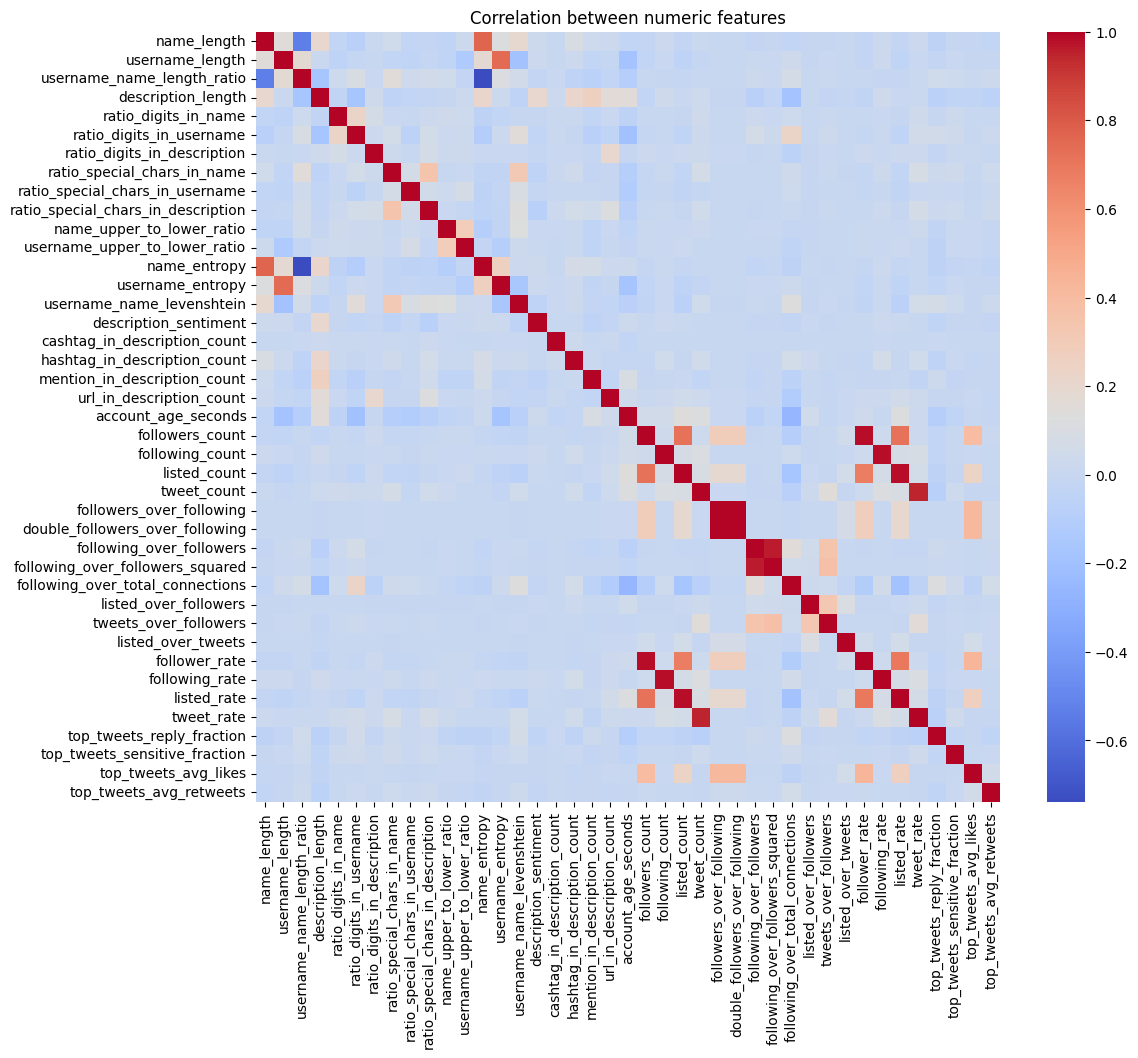

In [18]:
# Check pairwise correlations between numeric features
corr_matrix = X_train[numeric_cols].corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm')
plt.title("Correlation between numeric features")
plt.show()

In [19]:
from itertools import combinations

threshold = 0.8
high_corr = []

for col1, col2 in combinations(numeric_cols, 2):
    corr_val = corr_matrix.loc[col1, col2]
    if abs(corr_val) > threshold:
        high_corr.append((col1, col2, corr_val))

print("Highly correlated pairs (>|0.8|):")
for col1, col2, corr_val in high_corr:
    print(f"{col1} - {col2}: {corr_val:.2f}")

Highly correlated pairs (>|0.8|):
followers_count - follower_rate: 0.98
following_count - following_rate: 0.98
listed_count - listed_rate: 0.99
tweet_count - tweet_rate: 0.95
followers_over_following - double_followers_over_following: 1.00
following_over_followers - following_over_followers_squared: 0.96


In [20]:
# Check for numeric/boolean features with low variance
variances = X_train[numeric_bool_cols].var()

low_variance = variances[variances < 0.01].sort_values()

print("Features with variance < 0.01:")
for feature, var in low_variance.items():
    print(f"{feature}: {var:.6f}")

Features with variance < 0.01:
has_username: 0.000000
listed_rate: 0.000000
following_rate: 0.000000
tweet_rate: 0.000000
follower_rate: 0.000003
has_name: 0.000020
ratio_digits_in_description: 0.000732
has_bot_word_in_name: 0.001005
ratio_digits_in_name: 0.001413
has_bot_word_in_description: 0.001893
ratio_special_chars_in_username: 0.001893
is_protected: 0.001917
top_tweets_sensitive_fraction: 0.003990


In [21]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [35]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class SentenceEmbedder(BaseEstimator, TransformerMixin):
    def __init__(self, model_name="sentence-transformers/all-MiniLM-L6-v2"):
      self.model_name = model_name
      self.model = SentenceTransformer(self.model_name)

    def fit(self, X, y=None):
      return self

    def transform(self, X):
      if isinstance(X, pd.Series):
        X = X.values

      embeddings = self.model.encode(
          X,
          batch_size=1024,
          show_progress_bar=True,
          device=device
          )  # (n_samples, embedding_dim)

      out = np.empty((len(X), 1), dtype=object)
      out[:, 0] = list(embeddings)

      torch.cuda.empty_cache()

      return out

In [ ]:
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_bool_pipeline = Pipeline([
    ("var_thresh", VarianceThreshold(threshold=0.01)),  # remove features with variance < 0.01
    ("model_sel", SelectFromModel(
        GradientBoostingClassifier(n_estimators=100, random_state=42),
        threshold="median"  # keep features above median importance
    ))
])

preprocessor = ColumnTransformer([
    ("numeric_bool_pipeline", numeric_bool_pipeline, numeric_bool_cols),
    ("desc_text_embedding", SentenceEmbedder("sentence-transformers/all-MiniLM-L6-v2"), text_cols[0]),
    ("tweet_text_embedding", SentenceEmbedder("sentence-transformers/all-MiniLM-L6-v2"), text_cols[1])
    ], remainder="drop")

# Fit on training set
preprocessor.fit(X_train, y_train)

# Transform train/test sets
X_train_selected = preprocessor.transform(X_train)
X_test_selected = preprocessor.transform(X_test)

In [ ]:
np.save(f"{path}/en/v1/X_train_selected.npy", X_train_selected)
np.save(f"{path}/en/v1/X_test_selected.npy", X_test_selected)

In [ ]:
import joblib

numeric_bool_pipeline_fitted = preprocessor.named_transformers_['numeric_bool_pipeline']
joblib.dump(numeric_bool_pipeline_fitted, f"{path}/en/v1/numeric_bool_pipeline_fitted.joblib")

In [ ]:
import numpy as np
X_train_selected = np.load(f"{path}/en/v1/X_train_selected.npy", allow_pickle=True)
X_test_selected = np.load(f"{path}/en/v1/X_test_selected.npy", allow_pickle=True)

In [ ]:
import joblib
numeric_bool_pipeline_fitted = joblib.load(f"{path}/en/v1/numeric_bool_pipeline_fitted.joblib")

In [33]:
X_train_selected.shape

(250404, 787)

In [29]:
var_mask = numeric_bool_pipeline_fitted.named_steps['var_thresh'].get_support()
cols_after_var = numeric_bool_cols[var_mask]

sfm = numeric_bool_pipeline_fitted.named_steps['model_sel']
model_mask = sfm.get_support()
numeric_bool_cols_selected = cols_after_var[model_mask]

passthrough_cols = [col for col in X_train.columns if col not in numeric_bool_cols]

all_selected_cols = list(numeric_bool_cols_selected) + passthrough_cols

X_train_selected_df = pd.DataFrame(X_train_selected, columns=all_selected_cols, index=X_train.index)
X_test_selected_df = pd.DataFrame(X_test_selected, columns=all_selected_cols, index=X_test.index)

# Restore feature types
numeric_cols_selected = [col for col in numeric_bool_cols_selected if col in numeric_cols]
bool_cols_selected = [col for col in numeric_bool_cols_selected if col in bool_cols]

X_train_selected_df[numeric_cols_selected] = X_train_selected_df[numeric_cols_selected].astype(float)
X_test_selected_df[numeric_cols_selected] = X_test_selected_df[numeric_cols_selected].astype(float)

X_train_selected_df[bool_cols_selected] = X_train_selected_df[bool_cols_selected].astype(int)
X_test_selected_df[bool_cols_selected] = X_test_selected_df[bool_cols_selected].astype(int)

ValueError: Shape of passed values is (250404, 787), indices imply (250404, 22)

In [ ]:
X_train.head(2)

,name_length,username_length,username_name_length_ratio,description,description_length,has_name,has_username,has_description,has_url,has_location,has_pinned_tweet,has_bot_word_in_name,has_bot_word_in_description,ratio_digits_in_name,ratio_digits_in_username,ratio_digits_in_description,ratio_special_chars_in_name,ratio_special_chars_in_username,ratio_special_chars_in_description,name_upper_to_lower_ratio,username_upper_to_lower_ratio,name_entropy,username_entropy,username_name_levenshtein,description_sentiment,cashtag_in_description_count,hashtag_in_description_count,mention_in_description_count,url_in_description_count,is_protected,is_verified,account_age_seconds,followers_count,following_count,listed_count,tweet_count,followers_over_following,double_followers_over_following,following_over_followers,following_over_followers_squared,following_over_total_connections,listed_over_followers,tweets_over_followers,listed_over_tweets,follower_rate,following_rate,listed_rate,tweet_rate,top_tweets_concatenated_text,top_tweets_reply_fraction,top_tweets_num_distinct_langs,top_tweets_sensitive_fraction,top_tweets_avg_likes,top_tweets_avg_retweets
165336,11,11,1.000000,,0,True,True,False,False,True,False,False,False,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.250000,0.250000,3.095795,3.095795,0.909091,0.000000,0,0,0,0,False,False,288822607,20,76,0,2,0.263158,0.526316,3.800000,0.190000,0.791667,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,<USER> <USER> Carpet mill East Ardsley I can h...,1.000000,1,0.000000,0.000000,0.000000
154804,15,11,0.733333,"Fintech, crypto, NFT. Founder <USER> <USER>. A...",156,True,True,True,True,True,False,False,False,0.000000,0.000000,0.000000,0.066667,0.000000,0.102564,0.181818,0.000000,3.189898,3.095795,0.933333,0.000000,0,0,5,0,False,False,487716815,5664,556,486,13613,10.187050,20.374101,0.098164,0.000017,0.089389,0.085805,2.403425,0.035701,0.000012,0.000001,0.000001,0.000028,I'm doing my DYOR on $LUNA and it seems that i...,0.000000,1,0.000000,0.000000,2335.666667


In [ ]:
X_train_selected_df.head(2)

,name_length,username_name_length_ratio,description_length,ratio_special_chars_in_name,ratio_special_chars_in_description,hashtag_in_description_count,mention_in_description_count,account_age_seconds,followers_count,following_count,tweet_count,following_over_followers,listed_over_followers,tweets_over_followers,listed_over_tweets,top_tweets_num_distinct_langs,top_tweets_avg_likes,top_tweets_avg_retweets,has_description,is_verified,description,top_tweets_concatenated_text
165336,11.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,288822607.000000,20.000000,76.000000,2.000000,3.800000,0.000000,0.100000,0.000000,1.000000,0.000000,0.000000,0,0,"[0.014341043, -0.027605772, -0.032804664, -0.0...","[0.06489195, -0.03907821, 0.039468978, -0.0560..."
154804,15.000000,0.733333,156.000000,0.066667,0.102564,0.000000,5.000000,487716815.000000,5664.000000,556.000000,13613.000000,0.098164,0.085805,2.403425,0.035701,1.000000,0.000000,2335.666667,1,0,"[-0.035987668, 0.011791925, 0.049600534, -0.02...","[-0.0020513302, 0.019294605, -0.012940815, -0...."


In [ ]:
X_train_selected_df.dtypes

,0
name_length,float64
username_name_length_ratio,float64
description_length,float64
ratio_special_chars_in_name,float64
ratio_special_chars_in_description,float64
hashtag_in_description_count,float64
mention_in_description_count,float64
account_age_seconds,float64
followers_count,float64
following_count,float64


In [ ]:
print("Selected numeric/boolean features:")
print(list(numeric_bool_cols_selected))

Selected numeric/boolean features:
['name_length', 'username_name_length_ratio', 'description_length', 'ratio_special_chars_in_name', 'ratio_special_chars_in_description', 'hashtag_in_description_count', 'mention_in_description_count', 'account_age_seconds', 'followers_count', 'following_count', 'tweet_count', 'following_over_followers', 'listed_over_followers', 'tweets_over_followers', 'listed_over_tweets', 'top_tweets_num_distinct_langs', 'top_tweets_avg_likes', 'top_tweets_avg_retweets', 'has_description', 'is_verified']


In [ ]:
# Check feature importances
importances = sfm.estimator_.feature_importances_[model_mask]

feat_importances = pd.DataFrame({
    "feature": numeric_bool_cols_selected,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(feat_importances)

                               feature  importance
8                      followers_count    0.499868
2                   description_length    0.110718
10                         tweet_count    0.109413
18                     has_description    0.093354
9                      following_count    0.062435
17             top_tweets_avg_retweets    0.025300
19                         is_verified    0.021786
7                  account_age_seconds    0.016460
1           username_name_length_ratio    0.009408
4   ratio_special_chars_in_description    0.008724
3          ratio_special_chars_in_name    0.007130
5         hashtag_in_description_count    0.005608
12               listed_over_followers    0.004266
14                  listed_over_tweets    0.003936
0                          name_length    0.003742
15       top_tweets_num_distinct_langs    0.003185
16                top_tweets_avg_likes    0.002327
6         mention_in_description_count    0.001639
13               tweets_over_fo

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit on training set
scaler.fit(X_train_selected_df[numeric_cols_selected])

# Transform train/test sets
X_train_scaled = X_train_selected_df.copy()
X_test_scaled = X_test_selected_df.copy()

X_train_scaled[numeric_cols_selected] = scaler.transform(X_train_selected_df[numeric_cols_selected])
X_test_scaled[numeric_cols_selected] = scaler.transform(X_test_selected_df[numeric_cols_selected])

In [ ]:
X_train_scaled.head(2)

,name_length,username_name_length_ratio,description_length,ratio_special_chars_in_name,ratio_special_chars_in_description,hashtag_in_description_count,mention_in_description_count,account_age_seconds,followers_count,following_count,tweet_count,following_over_followers,listed_over_followers,tweets_over_followers,listed_over_tweets,top_tweets_num_distinct_langs,top_tweets_avg_likes,top_tweets_avg_retweets,has_description,is_verified,description,top_tweets_concatenated_text
165336,-0.502771,0.064187,-2.085108,-0.381874,-0.650481,-0.363490,-0.489250,-0.699049,-0.090620,-0.145197,-0.237651,0.091031,-0.172577,-0.030524,-0.022254,-0.695240,-0.047600,-0.124132,0,0,"[0.014341043, -0.027605772, -0.032804664, -0.0...","[0.06489195, -0.03907821, 0.039468978, -0.0560..."
154804,0.030390,-0.287965,1.009373,-0.023766,0.019873,-0.363490,3.660570,0.795050,-0.084637,-0.121590,-0.136391,-0.087700,0.410938,-0.026806,-0.015071,-0.695240,-0.047600,0.372063,1,0,"[-0.035987668, 0.011791925, 0.049600534, -0.02...","[-0.0020513302, 0.019294605, -0.012940815, -0...."


In [ ]:
from torch import nn

class MultiBranchNN(nn.Module):
  def __init__(self, numeric_dim, desc_text_dim, tweet_text_dim, hidden_dim=128, out_dim=1, dropout=0.5):
    super(MultiBranchNN, self).__init__()

    # Branch for numeric + boolean features
    self.numeric_branch = nn.Sequential(
        nn.Linear(numeric_dim, hidden_dim // 2),
        nn.LeakyReLU(),
        nn.Dropout(dropout)
        )

    # Branch for description text embeddings
    self.desc_branch = nn.Sequential(
        nn.Linear(desc_text_dim, hidden_dim // 4),
        nn.LeakyReLU(),
        nn.Dropout(dropout)
        )

    # Branch for tweet text embeddings
    self.tweet_branch = nn.Sequential(
        nn.Linear(tweet_text_dim, hidden_dim // 4),
        nn.LeakyReLU(),
        nn.Dropout(dropout)
        )

    # Combined layers
    self.combined = nn.Sequential(
        nn.Linear(hidden_dim, hidden_dim),
        nn.LeakyReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden_dim, out_dim)
        )

  def forward(self, x_numeric, x_desc, x_tweet):
    # Process each branch
    num_feat = self.numeric_branch(x_numeric)
    desc_feat = self.desc_branch(x_desc)
    tweet_feat = self.tweet_branch(x_tweet)

    # Concatenate branch outputs
    x = torch.cat([num_feat, desc_feat, tweet_feat], dim=1)

    # Final layers
    x = self.combined(x)
    return x

In [ ]:
X_train_numeric_bool = X_train_scaled[numeric_bool_cols_selected].astype(np.float32).to_numpy()
X_train_desc = np.stack(X_train_scaled['description'].values)
X_train_tweet = np.stack(X_train_scaled['top_tweets_truncated_texts_concat'].values)

#X_train_text = np.hstack([np.stack(X_train_scaled[col].values) for col in text_cols])
#X_train_embedded = np.hstack([X_train_numeric_bool, X_train_text])

X_test_numeric_bool = X_test_scaled[numeric_bool_cols_selected].astype(np.float32).to_numpy()
X_test_desc = np.stack(X_test_scaled['description'].values)
X_test_tweet = np.stack(X_test_scaled['top_tweets_truncated_texts_concat'].values)

#X_test_text = np.hstack([np.stack(X_test_scaled[col].values) for col in text_cols])
#X_test_embedded = np.hstack([X_test_numeric_bool, X_test_text])

In [ ]:
X_train_combined = np.hstack([X_train_numeric_bool, X_train_desc, X_train_tweet])
X_train_combined.shape

(283331, 1044)

In [ ]:
from imblearn.over_sampling import SMOTE

X_train_resampled, y_train_resampled = SMOTE(sampling_strategy=0.8, random_state=42).fit_resample(X_train_combined, y_train)

In [ ]:
y_train_resampled.value_counts(normalize=True)

,proportion
label,
0,0.555556
1,0.444444


In [ ]:
num_dim = X_train_numeric_bool.shape[1]
desc_dim = X_train_desc.shape[1]
tweet_dim = X_train_tweet.shape[1]

X_train_numeric_resampled = X_train_resampled[:, :num_dim]
X_train_desc_resampled = X_train_resampled[:, num_dim:num_dim+desc_dim]
X_train_tweet_resampled = X_train_resampled[:, num_dim+desc_dim:]

In [ ]:
X_train_tweet_resampled.shape

(471562, 512)

In [ ]:
X_train_numeric_tensor = torch.from_numpy(X_train_numeric_resampled)
X_train_desc_tensor = torch.from_numpy(X_train_desc_resampled)
X_train_tweet_tensor = torch.from_numpy(X_train_tweet_resampled)

y_train_tensor = torch.from_numpy(y_train_resampled.values).float()

X_test_numeric_tensor = torch.from_numpy(X_test_numeric_bool)
X_test_desc_tensor = torch.from_numpy(X_test_desc)
X_test_tweet_tensor = torch.from_numpy(X_test_tweet)

y_test_tensor = torch.from_numpy(y_test.values).float()

In [ ]:
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

train_dataset = TensorDataset(
    X_train_numeric_tensor,
    X_train_desc_tensor,
    X_train_tweet_tensor,
    y_train_tensor
    )
test_dataset = TensorDataset(
    X_test_numeric_tensor,
    X_test_desc_tensor,
    X_test_tweet_tensor,
    y_test_tensor
    )

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
numeric_dim = X_train_numeric_tensor.shape[1]
desc_text_dim = X_train_desc_tensor.shape[1]
tweet_text_dim = X_train_tweet_tensor.shape[1]

model = MultiBranchNN(
    numeric_dim=numeric_dim,
    desc_text_dim=desc_text_dim,
    tweet_text_dim=tweet_text_dim,
    hidden_dim=128,
    out_dim=1,
    dropout=0.5
    ).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [ ]:
def train(model, dataloader, criterion, optimizer, device):
  model.train()
  total_loss = 0

  for x_num, x_desc, x_tweet, y in dataloader:
    x_num, x_desc, x_tweet, y = x_num.to(device), x_desc.to(device), x_tweet.to(device), y.to(device).unsqueeze(1)

    optimizer.zero_grad()
    outputs = model(x_num, x_desc, x_tweet)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    total_loss += loss.item() * x_num.size(0)

  return total_loss / len(dataloader.dataset)

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

def evaluate(model, dataloader, criterion, device):
  model.eval()
  total_loss = 0
  all_preds = []
  all_targets = []

  with torch.no_grad():
      for x_num, x_desc, x_tweet, y in dataloader:
          x_num, x_desc, x_tweet, y = x_num.to(device), x_desc.to(device), x_tweet.to(device), y.to(device).unsqueeze(1)
          outputs = model(x_num, x_desc, x_tweet)
          loss = criterion(outputs, y)
          total_loss += loss.item() * x_num.size(0)

          preds = (torch.sigmoid(outputs) > 0.5).float()
          all_preds.append(preds.cpu())
          all_targets.append(y.cpu())

  all_preds = torch.cat(all_preds, dim=0)
  all_targets = torch.cat(all_targets, dim=0)

  accuracy = (all_preds == all_targets).sum().item() / len(all_targets)
  f1 = f1_score(all_targets.numpy(), all_preds.numpy())
  precision = precision_score(all_targets.numpy(), all_preds.numpy())
  recall = recall_score(all_targets.numpy(), all_preds.numpy())

  avg_loss = total_loss / len(dataloader.dataset)

  return avg_loss, accuracy, f1, precision, recall

In [ ]:
num_epochs = 5

for epoch in range(1, num_epochs + 1):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc, test_f1, test_prec, test_rec = evaluate(model, test_loader, criterion, device)

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | "
          f"Test Acc: {test_acc:.4f} | Test F1: {test_f1:.4f} | Test Prec: {test_prec:.4f} | Test Rec: {test_rec:.4f}")

Epoch 01 | Train Loss: 0.4086 | Test Loss: 0.3698 | Test Acc: 0.8207 | Test F1: 0.3698 | Test Prec: 0.2515 | Test Rec: 0.6981
Epoch 02 | Train Loss: 0.3545 | Test Loss: 0.3628 | Test Acc: 0.8275 | Test F1: 0.3750 | Test Prec: 0.2579 | Test Rec: 0.6868
Epoch 03 | Train Loss: 0.3317 | Test Loss: 0.3087 | Test Acc: 0.8578 | Test F1: 0.3972 | Test Prec: 0.2918 | Test Rec: 0.6218


KeyboardInterrupt: 